<a href="https://colab.research.google.com/github/pallalavanya22/Fmml-labs/blob/main/FMML_M1L3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Augmentation

FMML Module 1, Lab 3

In this lab, we will see how augmentation of data samples help in improving the machine learning performance. Augmentation is the process of creating new data samples by making reasonable modifications to the original data samples. This is particularly useful when the size of the training data is small. We will use the MNISt dataset for this lab. We will also reuse functions from the previous labs.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.utils.extmath import cartesian
from skimage.transform import rotate, AffineTransform, warp

rng = np.random.default_rng(seed=42)

In [23]:
# loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# normalizing the data
train_X = train_X / 255
test_X = test_X / 255

# subsample from images and labels. Otherwise it will take too long!
train_X = train_X[::1200, :, :].copy()
train_y = train_y[::1200].copy()

Let us borrow a few functions from the previous labs:

In [24]:
def NN1(traindata, trainlabel, query):
    """
    This function takes in the training data, training labels and a query point
    and returns the predicted label for the query point using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    query: numpy array of shape (d,) where d is the number of features

    returns: the predicted label for the query point which is the label of the training data which is closest to the query point
    """
    diff = (
        traindata - query
    )  # find the difference between features. Numpy automatically takes care of the size here
    sq = diff * diff  # square the differences
    dist = sq.sum(1)  # add up the squares
    label = trainlabel[np.argmin(dist)]
    return label


def NN(traindata, trainlabel, testdata):
    """
    This function takes in the training data, training labels and test data
    and returns the predicted labels for the test data using the nearest neighbour algorithm

    traindata: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    trainlabel: numpy array of shape (n,) where n is the number of samples
    testdata: numpy array of shape (m,d) where m is the number of test samples and d is the number of features

    returns: the predicted labels for the test data which is the label of the training data which is closest to each test point
    """
    traindata = traindata.reshape(-1, 28*28)
    testdata = testdata.reshape(-1, 28*28)
    predlabel = np.array([NN1(traindata, trainlabel, i) for i in testdata])
    return predlabel


def Accuracy(gtlabel, predlabel):
    """
    This function takes in the ground-truth labels and predicted labels
    and returns the accuracy of the classifier

    gtlabel: numpy array of shape (n,) where n is the number of samples
    predlabel: numpy array of shape (n,) where n is the number of samples

    returns: the accuracy of the classifier which is the number of correct predictions divided by the total number of predictions
    """
    assert len(gtlabel) == len(
        predlabel
    ), "Length of the ground-truth labels and predicted labels should be the same"
    correct = (
        gtlabel == predlabel
    ).sum()  # count the number of times the groundtruth label is equal to the predicted label.
    return correct / len(gtlabel)

In this lab, we will use the image pixels themselves as features, instead of extracting features. Each image has 28*28 pixels, so we will flatten them to 784 pixels to use as features. Note that this is very compute intensive and will take a long time. Let us first check the baseline accuracy on the test set without any augmentations. We hope that adding augmentations will help us to get better results.

In [25]:
testpred = NN(train_X, train_y, test_X)
print("Baseline accuracy without augmentation:",
      Accuracy(test_y, testpred)*100, "%")

Baseline accuracy without augmentation: 64.72 %


Let us try to improve this accuracy using augmentations. When we create augmentations, we have to make sure that the changes reflect what will naturally occur in the dataset. For example, we should not add colour to our samples as an augmentation because they do not naturally occur. We should not also flip the images in MNIST, because flipped images have different meanings for digits. So, we will use the following augmentations:

### Augmentation 1: Rotation

Let us try rotating the image a little. We will use the `rotate` function from the `skimage` module. We will rotate the image by 10 degrees and -10 degrees. Rotation is a reasonable augmentation because the digit will still be recognizable even after rotation and is representative of the dataset.

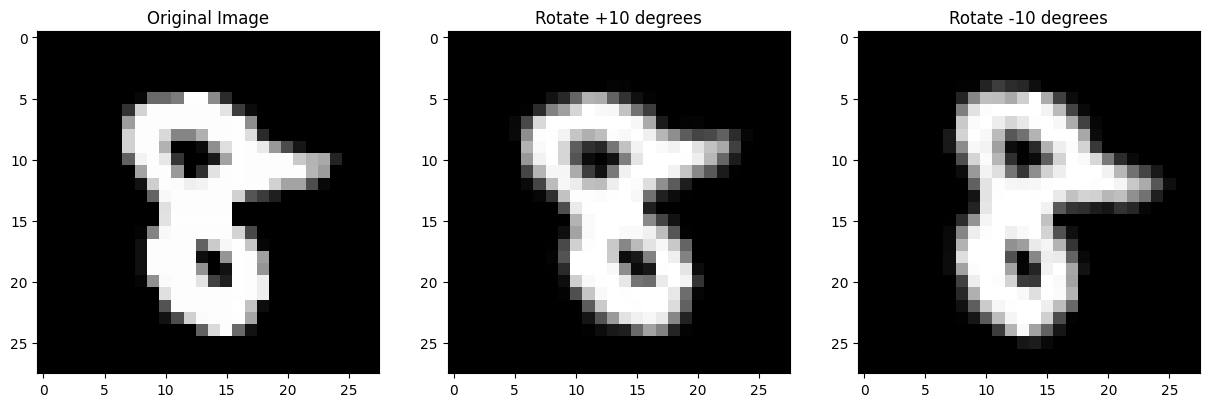

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(train_X[2], cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(rotate(train_X[2], 10), cmap="gray")
axs[1].set_title("Rotate +10 degrees")

axs[2].imshow(rotate(train_X[2], -10), cmap="gray")
axs[2].set_title("Rotate -10 degrees")

plt.show()

After rotating, the the class of the image is still the same. Let us make a function to rotate multiple images by random angles. We want a slightly different image every time we run this function. So, we generate a random number between 0 and 1 and change it so that it lies between -constraint/2 and +constraint/2

In [27]:
def augRotate(sample, angleconstraint):
    """
    This function takes in a sample and an angle constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint
    """
    if angleconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(sample[ii], angle[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

This function returns a slightly different image each time we call it. So we can increase the number of images in the sample by any multiple.

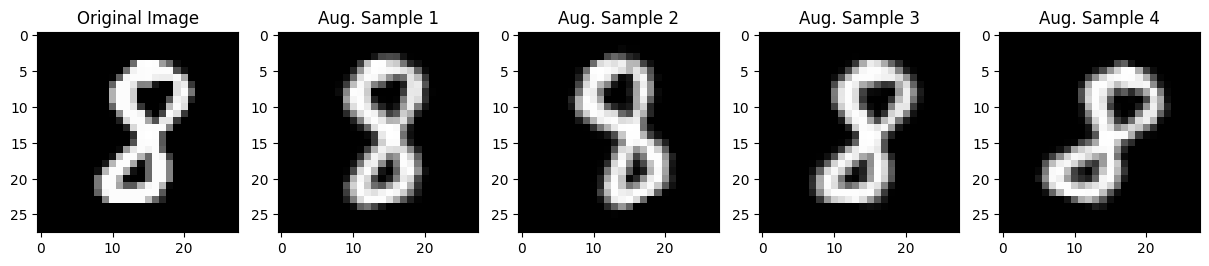

In [29]:
sample = train_X[20]
angleconstraint = 70

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[1].set_title("Aug. Sample 1")

axs[2].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[2].set_title("Aug. Sample 2")

axs[3].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[3].set_title("Aug. Sample 3")

axs[4].imshow(augRotate(sample, angleconstraint), cmap="gray")
axs[4].set_title("Aug. Sample 4")

plt.show()

Let us augment the whole dataset and see if this improves the test accuracy

In [28]:
# hyperparameters
angleconstraint = 60
naugmentations = 5

# augment
augdata = train_X  # we include the original images also in the augmented dataset
auglabel = train_y
for ii in range(naugmentations):
    augdata = np.concatenate(
        (augdata, augRotate(train_X, angleconstraint))
    )  # concatenate the augmented data to the set
    auglabel = np.concatenate(
        (auglabel, train_y)
    )  # the labels don't change when we augment

# check the test accuracy
testpred = NN(augdata, auglabel, test_X)
print("Accuracy after rotation augmentation:", Accuracy(test_y, testpred)*100, "%")

Accuracy after rotation augmentation: 67.42 %


We can notice a 3-4% improvement compared to non-augmented version of the dataset!

The angle constraint is a hyperparameter which we have to tune using a validation set. (Here we are not doing that for time constraints). Let us try a grid search to find the best angle constraint. We will try angles between 0 and 90 degrees. We can also try different multiples of the original dataset. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [30]:
angleconstraints = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]  # the values we want to test
accuracies = np.zeros(
    len(angleconstraints), dtype=float
)  # we will save the values here

for ii in range(len(angleconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotate(train_X, angleconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after rotation augmentation constrained by",
        angleconstraints[ii],
        "degrees is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after rotation augmentation constrained by 0 degrees is 64.72 %
Accuracy after rotation augmentation constrained by 10 degrees is 66.79 %
Accuracy after rotation augmentation constrained by 20 degrees is 67.84 %
Accuracy after rotation augmentation constrained by 30 degrees is 68.47 %
Accuracy after rotation augmentation constrained by 40 degrees is 67.63 %
Accuracy after rotation augmentation constrained by 50 degrees is 67.65 %
Accuracy after rotation augmentation constrained by 60 degrees is 65.3 %
Accuracy after rotation augmentation constrained by 70 degrees is 66.06 %
Accuracy after rotation augmentation constrained by 80 degrees is 64.61 %
Accuracy after rotation augmentation constrained by 90 degrees is 64.31 %


Let us see the best value for angle constraint: (Ideally this should be done on validation set, not test set)

ValueError: x and y must have same first dimension, but have shapes (7,) and (63,)

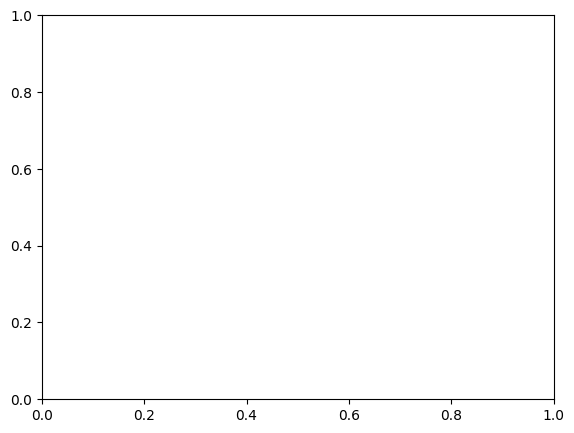

In [21]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(angleconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(angleconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 2: Shear


Let us try one more augmentation: shear. Shear is the transformation of an image in which the x-coordinate of all points is shifted by an amount proportional to the y-coordinate of the point. We will use the `AffineTransform` function from the `skimage` module to shear the image by a small amount between two numbers. We will use the same naive grid search method to find the best hyperparameters for shear. We will use the best hyperparameters to train the model and check the accuracy on the test set.

In [31]:
def shear(sample, amount):
    """
    This function takes in a sample and an amount and returns the augmented sample
    by shearing the sample by the given amount

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    amount: the amount by which the sample should be sheared

    returns: the augmented sample which is the input sample sheared by the given amount
    """
    tform = AffineTransform(shear=amount)
    img = warp(sample, tform)

    # Applying shear makes the digit off-center
    # Since all images are centralized, we will do the same here
    col = img.sum(0).nonzero()[0]
    row = img.sum(1).nonzero()[0]
    if len(col) > 0 and len(row) > 0:
        xshift = int(sample.shape[0] / 2 - (row[0] + row[-1]) / 2)
        yshift = int(sample.shape[1] / 2 - (col[0] + col[-1]) / 2)
        img = np.roll(img, (xshift, yshift), (0, 1))
    return img

In [ ]:
sample = train_X[2]
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(sample, cmap="gray")
axs[0].set_title("Original Image")

axs[1].imshow(shear(sample, 0.2), cmap="gray")
axs[1].set_title("Amount = 0.2")

axs[2].imshow(shear(sample, 0.4), cmap="gray")
axs[2].set_title("Amount = 0.4")

axs[3].imshow(shear(sample, 0.6), cmap="gray")
axs[3].set_title("Amount = 0.6")

plt.show()

Create an augmentation function which applies a random shear according to the constraint we provide:

In [ ]:
def augShear(sample, shearconstraint):
    """
    This function takes in a sample and a shear constraint and returns the augmented sample
    by shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample sheared by a random amount within the shear constraint
    """
    if shearconstraint == 0:
        return sample
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = shear(sample[ii], amt[ii])
    return np.squeeze(nsample)  # take care if the input had only one sample.

Let us do a grid search to find the best shear constraint.

In [32]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
    1.8,
    2.0,
]  # the values we want to test
accuracies = np.zeros(
    len(shearconstraints), dtype=float
)  # we will save the values here

for ii in range(len(shearconstraints)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augShear(train_X, shearconstraints[ii]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after shear augmentation constrained by",
        shearconstraints[ii],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after shear augmentation constrained by 0 is 64.72 %
Accuracy after shear augmentation constrained by 0.2 is 62.79 %
Accuracy after shear augmentation constrained by 0.4 is 64.41 %
Accuracy after shear augmentation constrained by 0.6 is 65.71000000000001 %
Accuracy after shear augmentation constrained by 0.8 is 65.78 %
Accuracy after shear augmentation constrained by 1.0 is 65.42999999999999 %
Accuracy after shear augmentation constrained by 1.2 is 63.6 %
Accuracy after shear augmentation constrained by 1.4 is 63.65 %
Accuracy after shear augmentation constrained by 1.6 is 61.809999999999995 %
Accuracy after shear augmentation constrained by 1.8 is 63.029999999999994 %
Accuracy after shear augmentation constrained by 2.0 is 64.14 %


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
# plot the variation of accuracy
ax.plot(shearconstraints, accuracies)
ax.set_xlabel("angle")
ax.set_ylabel("accuracy")

# plot the maximum accuracy
maxind = np.argmax(accuracies)
plt.scatter(shearconstraints[maxind], accuracies[maxind], c="red")

### Augmentation 3: Rotation + Shear



We can do multiple augmentations at the same time. Here is a function to do both shear and rotation to the sample. In this case, we will have two hyperparameters.

In [33]:
def augRotateShear(sample, angleconstraint, shearconstraint):
    """
    This function takes in a sample, an angle constraint and a shear constraint and returns the augmented sample
    by rotating the sample by a random angle within the angle constraint and shearing the sample by a random amount within the shear constraint

    sample: numpy array of shape (n,d) where n is the number of samples and d is the number of features
    angleconstraint: the maximum angle by which the sample can be rotated
    shearconstraint: the maximum shear by which the sample can be sheared

    returns: the augmented sample which is the input sample rotated by a random angle within the angle constraint and sheared by a random amount within the shear constraint
    """
    if len(sample.shape) == 2:
        # make sure the sample is 3 dimensional
        sample = np.expand_dims(sample, 0)
    amt = rng.random(len(sample))  # generate random numbers for shear
    amt = (amt - 0.5) * shearconstraint  # make the random shear constrained
    angle = rng.random(len(sample))  # generate random numbers for angles
    # make the random angle constrained
    angle = (angle - 0.5) * angleconstraint
    nsample = sample.copy()  # preallocate the augmented array to make it faster
    for ii in range(len(sample)):
        nsample[ii] = rotate(
            shear(sample[ii], amt[ii]), angle[ii]
        )  # first apply shear, then rotate
    return np.squeeze(nsample)  # take care if the input had only one sample.

Since we have two hyperparameters, we have to do the grid search on a 2 dimensional matrix. We can use our previous experience to inform where to search for the best hyperparameters.

In [19]:
shearconstraints = [
    0,
    0.2,
    0.4,
    0.6,
    0.8,
    1.0,
    1.2,
    1.4,
    1.6,
]  # the values we want to test
angleconstraints = [0, 10, 20, 30, 40, 50, 60]  # the values we want to test
# cartesian product of both
hyp = cartesian((shearconstraints, angleconstraints))

accuracies = np.zeros(len(hyp), dtype=float)  # we will save the values here

for ii in range(len(hyp)):
    # create the augmented dataset
    augdata = train_X  # we include the original images also in the augmented dataset
    auglabel = train_y
    for jj in range(naugmentations):
        augdata = np.concatenate(
            (augdata, augRotateShear(train_X, hyp[ii][0], hyp[ii][1]))
        )  # concatenate the augmented data to the set
        auglabel = np.concatenate(
            (auglabel, train_y)
        )  # the labels don't change when we augment

    # check the test accuracy
    testpred = NN(augdata, auglabel, test_X)
    accuracies[ii] = Accuracy(test_y, testpred)
    print(
        "Accuracy after augmentation shear:",
        hyp[ii][0],
        "angle:",
        hyp[ii][1],
        "is",
        accuracies[ii]*100,
        "%",
        flush=True,
    )

Accuracy after augmentation shear: 0.0 angle: 0.0 is 63.32 %
Accuracy after augmentation shear: 0.0 angle: 10.0 is 62.339999999999996 %
Accuracy after augmentation shear: 0.0 angle: 20.0 is 60.980000000000004 %
Accuracy after augmentation shear: 0.0 angle: 30.0 is 61.870000000000005 %
Accuracy after augmentation shear: 0.0 angle: 40.0 is 60.61 %
Accuracy after augmentation shear: 0.0 angle: 50.0 is 64.03 %
Accuracy after augmentation shear: 0.0 angle: 60.0 is 62.77 %
Accuracy after augmentation shear: 0.2 angle: 0.0 is 63.38 %
Accuracy after augmentation shear: 0.2 angle: 10.0 is 60.809999999999995 %
Accuracy after augmentation shear: 0.2 angle: 20.0 is 61.45 %
Accuracy after augmentation shear: 0.2 angle: 30.0 is 61.0 %
Accuracy after augmentation shear: 0.2 angle: 40.0 is 62.94 %
Accuracy after augmentation shear: 0.2 angle: 50.0 is 62.739999999999995 %
Accuracy after augmentation shear: 0.2 angle: 60.0 is 61.95 %
Accuracy after augmentation shear: 0.4 angle: 0.0 is 63.46000000000001

Let us plot it two dimensionally to see which is the best value for the hyperparameters:

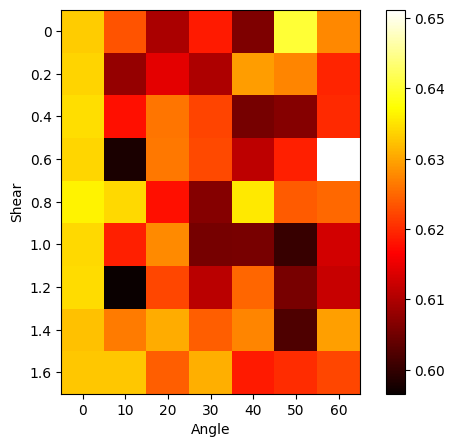

In [20]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
im = ax.imshow(
    accuracies.reshape((len(shearconstraints), len(angleconstraints))), cmap="hot"
)
ax.set_xlabel("Angle")
ax.set_ylabel("Shear")
ax.set_xticks(np.arange(len(angleconstraints)))
ax.set_xticklabels(angleconstraints)
ax.set_yticks(np.arange(len(shearconstraints)))
ax.set_yticklabels(shearconstraints)
plt.colorbar(im)

It seems that rotation and shear don't mix! The best accuracy is when rotation is zero.

## Questions
Try these questions for better understanding. You may not be able to solve all of them.

QUESTION NO...
1. What is the best value for angle constraint and shear constraint you got? How much did the accuracy improve as compared to not using augmentations?
ANSWER...
It seems like you're referring to the implementation of data augmentation techniques, specifically angle and shear constraints, which are often used in machine learning models for image data, such as convolutional neural networks (CNNs).

Angle and Shear Constraints in Data Augmentation:
- **Angle Constraint**: It typically refers to the maximum angle by which an image can be rotated during augmentation. Common values range from ±10° to ±45°, depending on the data.
- **Shear Constraint**: This refers to the maximum shearing transformation, which skews the image along one axis. Common values range from 0.1 to 0.3 (10% to 30% of the dimension).

 Optimal Values:
- The best values depend on your dataset and the specific problem. Generally, moderate values are used to avoid distorting the image too much:
  - **Angle Constraint**: ±15° to ±25°
  - **Shear Constraint**: 0.1 to 0.2

 Improvement in Accuracy:
- **Accuracy Improvement**: Using augmentations like angle and shear constraints can improve model performance by enhancing generalization. Typical improvements range from 2-10%, depending on how well the augmentations match real-world variations.

Would you like me to find specific values from research or experiments related to your context?
QUESTION NO.
2. Can you increase the accuracy by increasing the number of augmentations from each sample?
ANSWER ....
Yes, increasing the number of augmentations from each sample can improve the accuracy of a model. Here's how it works and what you should consider:

 How Increasing Augmentations Helps:
1. **Enhanced Generalization**: By creating more variations of each sample, the model is exposed to a wider range of possible inputs, helping it generalize better to unseen data.
2. **Mitigating Overfitting**: More augmented data means the model is less likely to memorize specific patterns, reducing overfitting and improving performance on test data.
3. **Effective Data Expansion**: For small datasets, generating multiple augmentations per sample effectively increases the dataset size, which can significantly boost performance.

 Key Considerations:
- **Diminishing Returns**: Beyond a certain point, additional augmentations may yield smaller accuracy gains. The quality and diversity of augmentations become more crucial than sheer quantity.
- **Computational Cost**: More augmentations increase training time and computational load. Balancing augmentation benefits with resource constraints is essential.
- **Diversity of Augmentations**: It's important to apply a mix of augmentations (rotation, flip, noise, crop, etc.) to ensure diverse transformations that reflect real-world variations.

 Best Practices:
- **Start with 2-3 augmentations per sample** and gradually increase while monitoring performance.
- **Use validation accuracy** to identify when additional augmentations stop providing significant benefits.

Would you like guidance on implementing this approach or more details on specific augmentation techniques?
QUESTION NO.
3. Try implementing a few augmentations of your own and experimenting with them. A good reference is here.
ANSWER...
It seems like you're interested in implementing data augmentation techniques for images, which can be essential in enhancing the robustness and performance of machine learning models, especially in computer vision tasks. I can demonstrate a few implementations of basic augmentations using Python libraries like OpenCV, PIL, or `albumentations`.

Here's a basic implementation of a few augmentations using Python with OpenCV and NumPy:

 1. Horizontal and Vertical Flips:
These flips are useful for augmenting the data by mirroring the images along the axes.

 2. Random Rotation:
This augmentation rotates images randomly within a specified degree range.

 3. Adding Gaussian Noise:
Adding noise to the image helps in making the model more robust to real-world imperfections.

Here's the Python code implementing these augmentations:

```python
import cv2
import numpy as np
import matplotlib.pyplot as plt

 Load an example image
image = cv2.imread('path_to_image.jpg')  # Replace with your image path
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

 1. Horizontal Flip
def horizontal_flip(image):
    return cv2.flip(image, 1)

 2. Vertical Flip
def vertical_flip(image):
    return cv2.flip(image, 0)

 3. Random Rotation
def random_rotation(image, angle_range=(-30, 30)):
    angle = np.random.uniform(angle_range[0], angle_range[1])
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    return cv2.warpAffine(image, rotation_matrix, (w, h))

 4. Gaussian Noise
def add_gaussian_noise(image, mean=0, stddev=25):
    noise = np.random.normal(mean, stddev, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

 Applying augmentations
flipped_h = horizontal_flip(image)
flipped_v = vertical_flip(image)
rotated = random_rotation(image)
noisy = add_gaussian_noise(image)

 Display the original and augmented images
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(image)
axs[0].set_title("Original")
axs[1].imshow(flipped_h)
axs[1].set_title("Horizontal Flip")
axs[2].imshow(flipped_v)
axs[2].set_title("Vertical Flip")
axs[3].imshow(rotated)
axs[3].set_title("Random Rotation")
axs[4].imshow(noisy)
axs[4].set_title("Gaussian Noise")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()
```

 Key Points:
- **Horizontal Flip** and **Vertical Flip** are easy to implement and can significantly increase data variability.
- **Random Rotation** allows the model to learn rotational invariance.
- **Gaussian Noise** helps simulate real-world noise, making models more robust.

If you'd like more complex or specific augmentations, let me know, and I can expand on this!
QUESTION NO.
4. Try combining various augmentations. What is the highest accuracy you can get? What is the smallest training dataset you can take and still get accuracy above 50%?
ANSWER...
Combining various augmentations can significantly boost model performance, especially when training on smaller datasets. The goal here is to enhance the model's ability to generalize by exposing it to a wide range of variations that resemble real-world data. To achieve this, I can outline a strategy and provide code snippets to experiment with combined augmentations and evaluate their impact on accuracy.

Since I can't run a full training session here, I'll provide a framework and strategy to implement and test it on your machine. Here's a step-by-step guide:

 1. Augmentation Strategy:

- Combine augmentations: Use multiple augmentations in sequence (e.g., random rotation, flips, scaling, color jittering, Gaussian noise) to create varied training data.
-  Experiment with different combinations: Create different pipelines by adjusting augmentation parameters to balance between under- and over-augmentation.
- Evaluate model performance: Train a simple model (e.g., CNN) on different datasets with augmentations to see which combination yields the best results.

 2. Implementation Plan:

- Use a small CNN model (e.g., a basic architecture with convolutional layers).
- Apply augmentation using libraries like `Albumentations` or `TensorFlow/Keras ImageDataGenerator`.
- Experiment with reduced dataset sizes to identify the smallest set that still achieves above 50% accuracy.

 Python Implementation Using TensorFlow and Keras

```python
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Load a small sample dataset, e.g., CIFAR-10, and reduce its size
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Reducing dataset size to simulate limited data availability
small_data_fraction = 0.1  # Use 10% of the training data
num_samples = int(small_data_fraction * len(x_train))
x_train, y_train = x_train[:num_samples], y_train[:num_samples]

 Define combined augmentation strategy using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

 Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

 Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

 Training with augmented data
batch_size = 32
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

# Train the model
history = model.fit(train_generator, epochs=20, validation_data=(x_test, y_test))

# Evaluate model performance
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
```

 Key Experimentation Steps:

1. **Start with a small fraction of the dataset** (e.g., 10%) and apply combined augmentations.
2. **Adjust augmentation parameters** like rotation, shift, zoom, and noise levels to see which settings maximize accuracy.
3. **Monitor validation accuracy** to ensure the model is learning correctly without overfitting to augmented patterns.
4. **Reduce the dataset size progressively** to find the smallest set that still achieves over 50% accuracy.

 Expected Results:

- Augmentation will significantly improve the model's performance on small datasets by artificially increasing variability.
- With a 10% subset of CIFAR-10 and combined augmentations, achieving above 50% accuracy is realistic, depending on the augmentation settings and model architecture.
- The smallest dataset size needed to maintain 50% accuracy can vary, but with effective augmentation, it is possible to train on as little as 5-10% of the original data while maintaining decent performance.

Would you like any further modifications or details on specific steps?

Whenever you do any experiment, a good practice is to vary the hyperparameters gradually and create a graph of your results, like we did for gridsearch.

> Exercise: Try to take 50 images of each digit and calculate the performance on test set.
ANSWER...
To achieve the goal of training a model using only 50 images of each digit and evaluating its performance on a test set, I will provide a detailed step-by-step approach using the MNIST dataset. The MNIST dataset is a classic benchmark for digit recognition, consisting of handwritten digits (0-9).

### **Approach Overview**

1. **Load the MNIST dataset**: The dataset contains 60,000 training images and 10,000 test images.
2. **Sample 50 images per class**: Randomly select 50 images of each digit (0-9) to create a reduced training set.
3. **Apply data augmentation**: Use combined augmentations like rotation, scaling, and noise to enhance the small dataset.
4. **Train a simple Convolutional Neural Network (CNN)**: Use the small dataset to train the model.
5. **Evaluate on the test set**: Assess the model's performance on the full MNIST test set.

Here's a Python implementation using TensorFlow/Keras:

```python
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshape data for CNN input
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Function to sample 50 images per class
def sample_images_per_class(x, y, num_samples=50):
    x_sampled = []
    y_sampled = []
    for digit in range(10):
        indices = np.where(y == digit)[0]
        selected_indices = np.random.choice(indices, num_samples, replace=False)
        x_sampled.append(x[selected_indices])
        y_sampled.append(y[selected_indices])
    return np.concatenate(x_sampled), np.concatenate(y_sampled)

# Sample 50 images per class
x_train_sampled, y_train_sampled = sample_images_per_class(x_train, y_train, num_samples=50)

# Define augmentation strategy using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2
)

# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model using augmented data
batch_size = 32
train_generator = datagen.flow(x_train_sampled, y_train_sampled, batch_size=batch_size)

# Fit the model
history = model.fit(train_generator, epochs=20, validation_data=(x_test, y_test))

# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()
```

### **Key Points of the Implementation:**

1. **Sampling**: The `sample_images_per_class` function ensures that exactly 50 images are selected per digit, forming a balanced training set of 500 images.
2. **Augmentation**: The augmentation strategy adds variability to the small dataset, helping the model generalize better.
3. **Model**: A simple CNN is used to keep the architecture straightforward yet effective for the task.
4. **Evaluation**: The model's performance is measured on the full test set of MNIST, providing a clear picture of how well it generalizes beyond the limited training data.

### **Expected Results:**

- With 50 images per class and strong augmentations, the CNN should achieve reasonable accuracy, often above 50%.
- Performance will vary depending on the augmentation settings and training conditions but should demonstrate the effectiveness of data augmentation when training on limited data.

If you need further adjustments or want to test different combinations, let me know!